In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

## Data Importing

In [77]:
# import data using kaggle API
# kaggle API token must be in ~/.kaggle/kaggle.json
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
# download and unzip data in current directory
api.dataset_download_files('guillemservera/sp500-nasdaq-spy-qqq-ohlcv-data', path='./', unzip=True)



## Data Cleaning

In [4]:
def data_preprocess(filepath):
    """Data cleaning and preprocessing for 4 raw datasets."""
    df = pd.read_csv(filepath)
    df = df.copy()
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df = df.set_index('date')
    # when adjusted close price that considers dividends and splits is available
    # use it as close price and drop close column for better valuation
    if 'adjusted_close' in df.columns:
        df.drop('close', axis=1, inplace=True)
        df.rename(columns={'adjusted_close':'close'}, inplace=True)
    # average moving prices and next day closing price for RF model
    df['avg_pri_5d']=df['close'].rolling(5).mean( )
    df['avg_pri_10d']=df['close'].rolling(10).mean( )
    df['avg_pri_20d']=df['close'].rolling(20).mean( )
    df['avg_pri_50d']=df['close'].rolling(50).mean( )
    df['close_nextday'] = df['close'].shift(-1)
    df.dropna(inplace=True)
    df = df[df['volume'] != 0] # remove rows with volume = 0
    return df


## Descriptive Analysis

Generates descriptive analysis for the 4 processed datasets:

In [5]:
SP500 = data_preprocess('SP500.csv')
# SP500.head()
SP500.describe()

,open,high,low,close,volume,change_percent,avg_vol_20d,avg_pri_5d,avg_pri_10d,avg_pri_20d,avg_pri_50d,close_nextday
count,18630.000000,18630.000000,18630.000000,18630.000000,1.863000e+04,18630.000000,1.863000e+04,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000
mean,786.283009,790.966441,781.320027,786.450354,1.134429e+09,0.035229,1.132579e+09,785.941116,785.304265,784.034741,780.298350,786.706086
std,1049.703036,1055.601087,1043.432414,1049.906343,1.713373e+09,0.992606,1.678322e+09,1049.052531,1048.004242,1045.924651,1039.945712,1050.298988
min,16.660000,16.660000,16.660000,16.660000,6.800000e+05,-20.470000,6.300000e+04,16.674000,16.626000,16.578000,16.273800,16.670000
25%,88.645000,89.410000,87.837500,88.645000,1.025000e+07,-0.410000,1.054675e+07,88.698000,88.696250,88.662125,88.295200,88.667500
50%,248.530000,250.105000,246.450000,248.630000,1.364850e+08,0.050000,1.445412e+08,248.393000,248.222000,247.702250,244.893300,248.745000
75%,1211.335000,1219.620000,1204.482500,1212.017500,1.859112e+09,0.510000,1.919180e+09,1210.906500,1207.491000,1206.116882,1209.857302,1212.154925
max,4804.509800,4818.620100,4780.980000,4796.560100,1.145623e+10,11.580000,7.701906e+09,4785.614080,4762.854060,4751.224080,4681.011610,4796.560100


In [6]:
ND100 = data_preprocess('NASDAQ_100.csv')
# ND100.head()
ND100.describe()

,open,high,low,close,volume,change_percent,avg_vol_20d,avg_pri_5d,avg_pri_10d,avg_pri_20d,avg_pri_50d,close_nextday
count,9606.000000,9606.000000,9606.000000,9606.000000,9.606000e+03,9606.000000,9.606000e+03,9606.000000,9606.000000,9606.000000,9606.000000,9606.000000
mean,3175.294083,3201.299693,3147.954977,3176.115308,1.680277e+09,0.064566,1.675076e+09,3172.645193,3168.329211,3159.729840,3134.394176,3177.869873
std,3899.689306,3928.798667,3868.684694,3900.826359,1.358949e+09,1.649800,1.314265e+09,3895.584299,3889.256056,3876.697644,3840.313241,3903.244903
min,125.230000,127.645000,125.170000,126.955000,3.174000e+07,-15.080000,1.752840e+08,126.037000,124.705000,122.661500,116.728700,126.955000
25%,500.432500,502.350000,495.127500,500.577500,4.923675e+08,-0.670000,4.935130e+08,496.842500,494.518000,489.699750,469.590050,500.822500
50%,1686.825000,1701.185000,1670.835000,1684.635000,1.684780e+09,0.120000,1.749327e+09,1685.327000,1685.242015,1682.382505,1682.231498,1685.130000
75%,3984.562525,4030.197475,3950.900025,3985.587575,2.099448e+09,0.840000,2.060666e+09,3989.682025,3956.791993,3942.864106,3946.822842,3986.064950
max,16963.519500,16969.169900,16891.320300,16906.800800,1.162119e+10,18.770000,8.052748e+09,16857.412500,16776.373250,16699.156645,16202.184216,16982.289100


In [7]:
SPY = data_preprocess('SPY.csv')
# SPY.head()
SPY.describe()

,open,high,low,volume,close,change_percent,avg_vol_20d,avg_pri_5d,avg_pri_10d,avg_pri_20d,avg_pri_50d,close_nextday
count,7748.000000,7748.000000,7748.000000,7.748000e+03,7748.000000,7748.000000,7.748000e+03,7748.000000,7748.000000,7748.000000,7748.000000,7748.000000
mean,171.673568,172.706894,170.535444,8.509320e+07,143.269320,0.044837,8.499604e+07,143.153363,143.008424,142.719657,141.871196,143.327527
std,107.032051,107.603055,106.431873,9.237740e+07,113.011180,1.183035,8.511630e+07,112.888004,112.737203,112.437947,111.587484,113.066644
min,43.343800,43.875000,43.281300,5.200000e+03,24.650300,-10.940000,7.584500e+04,24.845500,24.989240,25.082415,25.294040,24.650300
25%,106.348125,107.230000,105.469500,1.056072e+07,71.199900,-0.450000,9.876966e+06,71.023900,70.951427,70.679870,70.961634,71.210475
50%,132.555000,133.360000,131.425000,6.376929e+07,93.920400,0.070000,6.888490e+07,93.706380,93.675220,93.567900,93.607951,93.929350
75%,210.750000,211.500000,209.807100,1.168908e+08,181.892525,0.600000,1.185368e+08,181.585215,181.150675,180.807285,180.134059,181.912800
max,479.220000,479.980000,476.260000,8.715469e+08,476.690000,14.520000,5.389658e+08,475.680000,473.823000,473.375500,459.899496,476.690000


In [8]:
QQQ = data_preprocess('QQQ_raw.csv')
# QQQ.head()
QQQ.describe()

,open,high,low,volume,close,change_percent,avg_vol_20d,avg_pri_5d,avg_pri_10d,avg_pri_20d,avg_pri_50d,close_nextday
count,6206.000000,6206.000000,6206.000000,6.206000e+03,6206.000000,6206.000000,6.206000e+03,6206.000000,6206.000000,6206.000000,6206.000000,6206.000000
mean,116.184955,117.164544,115.105643,6.683902e+07,107.767707,0.049869,6.711196e+07,107.650941,107.505853,107.216629,106.366504,107.826691
std,101.123919,101.901966,100.290501,4.959372e+07,101.694131,1.722415,4.343072e+07,101.539074,101.352241,100.981346,99.909532,101.764976
min,19.940000,20.530000,19.760000,1.651000e+06,17.157900,-11.980000,8.672560e+06,17.358020,17.774560,18.192395,19.416450,17.157900
25%,41.940250,42.292500,41.502500,3.120310e+07,36.307500,-0.660000,3.376824e+07,36.332795,36.292125,36.259677,36.108986,36.307500
50%,69.465000,69.963750,68.720500,5.527259e+07,60.017850,0.110000,5.615302e+07,59.911310,59.695855,59.637402,59.199926,60.032600
75%,160.097500,161.647500,158.052500,8.905596e+07,146.582250,0.810000,9.024001e+07,146.236560,146.461995,144.564844,141.525033,146.698225
max,412.670000,412.920000,410.940000,6.167953e+08,411.500000,16.840000,3.326542e+08,410.229900,408.170460,406.308745,394.055426,412.990000


Different indices perform very differently due to their nature (e.g., different timeframes and stocks). Clearer performance can be seen from the visualised trends:

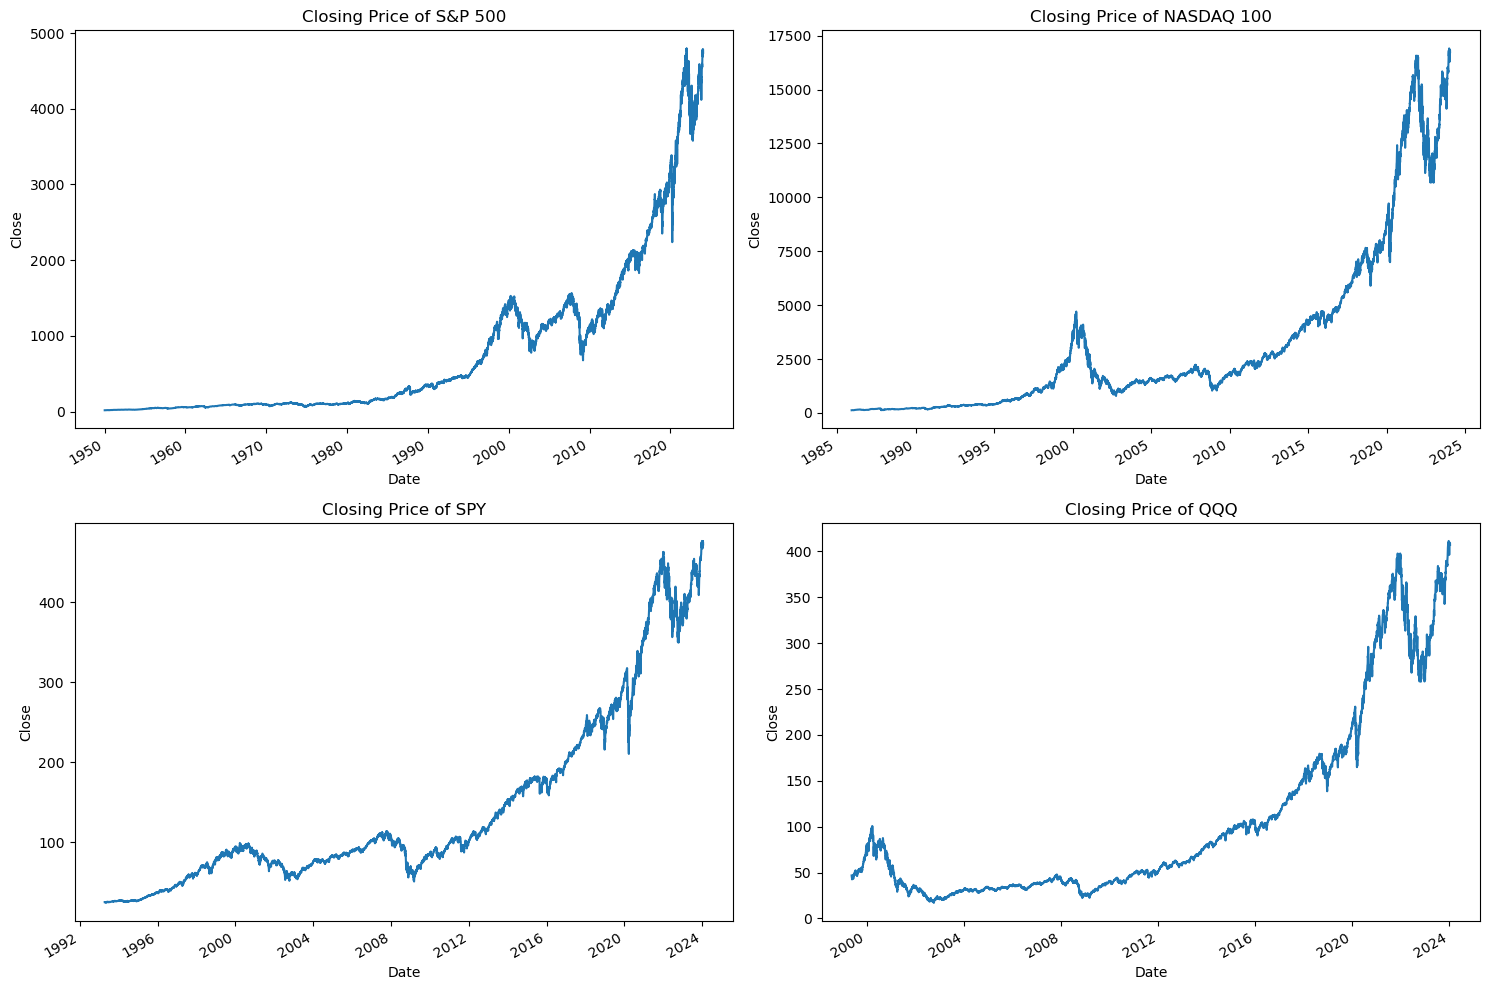

In [9]:
index_list = [SP500, ND100, SPY, QQQ]
label_list = ['S&P 500', 'NASDAQ 100', 'SPY', 'QQQ']

plt.figure(figsize=(15, 10))

for i, index in enumerate(index_list, 1):
    plt.subplot(2, 2, i)
    index['close'].plot()
    plt.ylabel('Close')
    plt.xlabel('Date')
    plt.title(f"Closing Price of {label_list[i - 1]}")

plt.tight_layout()
plt.show()


From the plot, it can be seen that for S&P 500, NASDAQ 100 and SPY, closing prices before 1995 show generally flat and stable trends, which makes little contribution to stock prediction. Besides, QQQ dataset starts from 1999-03-10. For data consistency, we will use 1999-03-10 as the starting date for all datasets. **(waiting for finalisation)**

In [11]:
# QQQ is not filtered as the original dataset starts from 1999-03-10
SP500_new = SP500.loc['1999-03-10':]
ND100_new = ND100.loc['1999-03-10':]
SPY_new = SPY.loc['1999-03-10':]
# SP500_new.head()
# ND100_new.head()
# SPY_new.head()
# QQQ.head()

We can also concatenate the dataframes into one:

In [12]:
# create copies to avoid warning
SP500_copy = SP500_new.copy()
ND100_copy = ND100_new.copy()
SPY_copy = SPY_new.copy()
QQQ_copy = QQQ.copy()

# add stock index column
SP500_copy['Stock Index'] = 'S&P 500'
ND100_copy['Stock Index'] = 'NASDAQ 100'
SPY_copy['Stock Index'] = 'SPY'
QQQ_copy['Stock Index'] = 'QQQ'
# concatenate the DataFrames
combined_df = pd.concat([SP500_copy, ND100_copy, SPY_copy, QQQ_copy])

# reorder the columns to bring 'Stock Index' to the front
column_order = ['Stock Index'] + [col for col in combined_df.columns if col != 'Stock Index']
combined_df = combined_df[column_order]
# display 2023 data as an example
display(combined_df[combined_df.index.year == 2023])







,Stock Index,open,high,low,close,volume,change_percent,avg_vol_20d,avg_pri_5d,avg_pri_10d,avg_pri_20d,avg_pri_50d,close_nextday
date,,,,,,,,,,,,,
2023-01-03,S&P 500,3853.2900,3878.4600,3794.3301,3824.1399,3959140000,-0.40,4.033436e+09,3825.07798,3831.03198,3891.793495,3901.430814,3852.9700
2023-01-04,S&P 500,3840.3601,3873.1599,3815.7700,3852.9700,4414080000,0.75,4.040099e+09,3829.82198,3834.56299,3884.499990,3903.435214,3808.1001
2023-01-05,S&P 500,3839.7400,3839.7400,3802.4199,3808.1001,3893450000,-1.16,4.016352e+09,3834.79800,3833.21099,3877.841995,3903.650414,3895.0801
2023-01-06,S&P 500,3823.3701,3906.1899,3809.5601,3895.0801,3923560000,2.28,4.006628e+09,3843.95802,3834.87501,3875.900005,3904.369814,3892.0901
2023-01-09,S&P 500,3910.8201,3950.5701,3890.4199,3892.0901,4311770000,-0.08,4.021872e+09,3854.47604,3841.84503,3872.329010,3905.599614,3919.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,QQQ,409.0000,409.9700,406.4787,408.1655,34314000,0.15,4.522905e+07,406.88018,403.60098,395.771005,379.058536,410.6640
2023-12-26,QQQ,409.2500,411.5600,409.1500,410.6640,22722500,0.61,4.465819e+07,407.63974,405.21494,396.894685,379.984606,411.5000
2023-12-27,QQQ,410.9500,411.7900,410.0800,411.5000,31980500,0.20,4.448266e+07,408.15072,406.59829,398.009295,380.845004,411.3000


Now as we have sychronised timeframe for all datasets, we can conduct several comparisons:

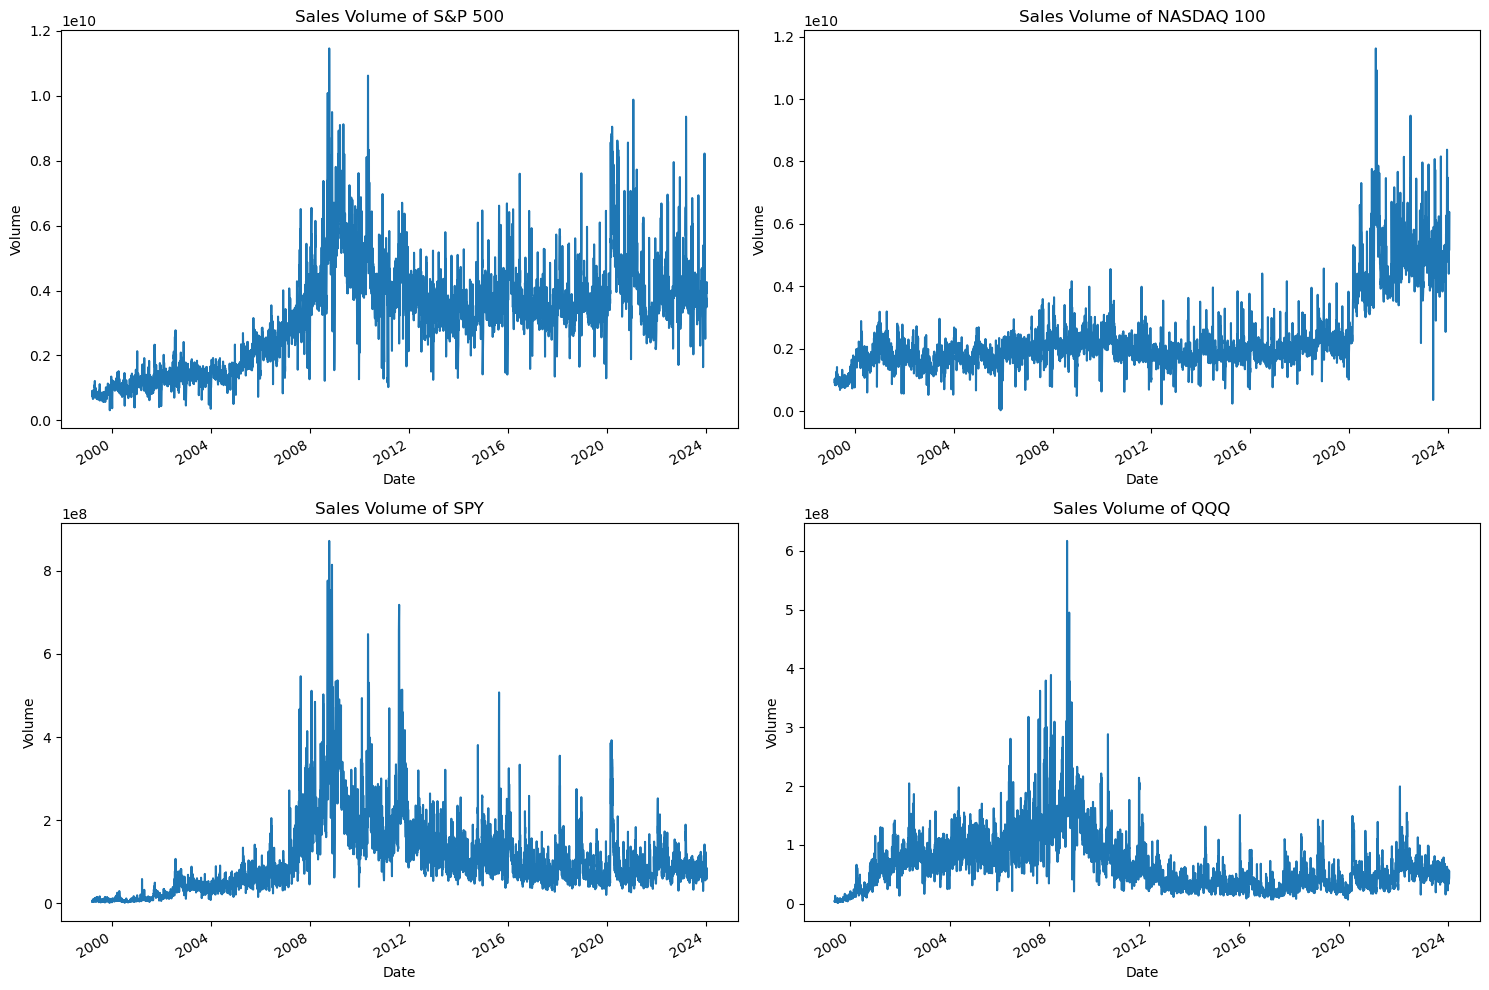

In [13]:
# compare sales volume
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['volume'].plot()   
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"Sales Volume of {stock_index}")

plt.tight_layout()
plt.show()

All datasets except Nasdaq 100 have their peaks in the post-global-financial crisis period. This might be because the Nasdaq 100 is made up only of **non-financial** corporates. Meanwhile, the Nasdaq 100 saw its biggest rise just after the Covid-19 pandemic hit, a time when the S&P 500 also saw a noticeable increase. This might attribute to the high proportion of tech companies in the two indices, especially for Nasdaq 100.

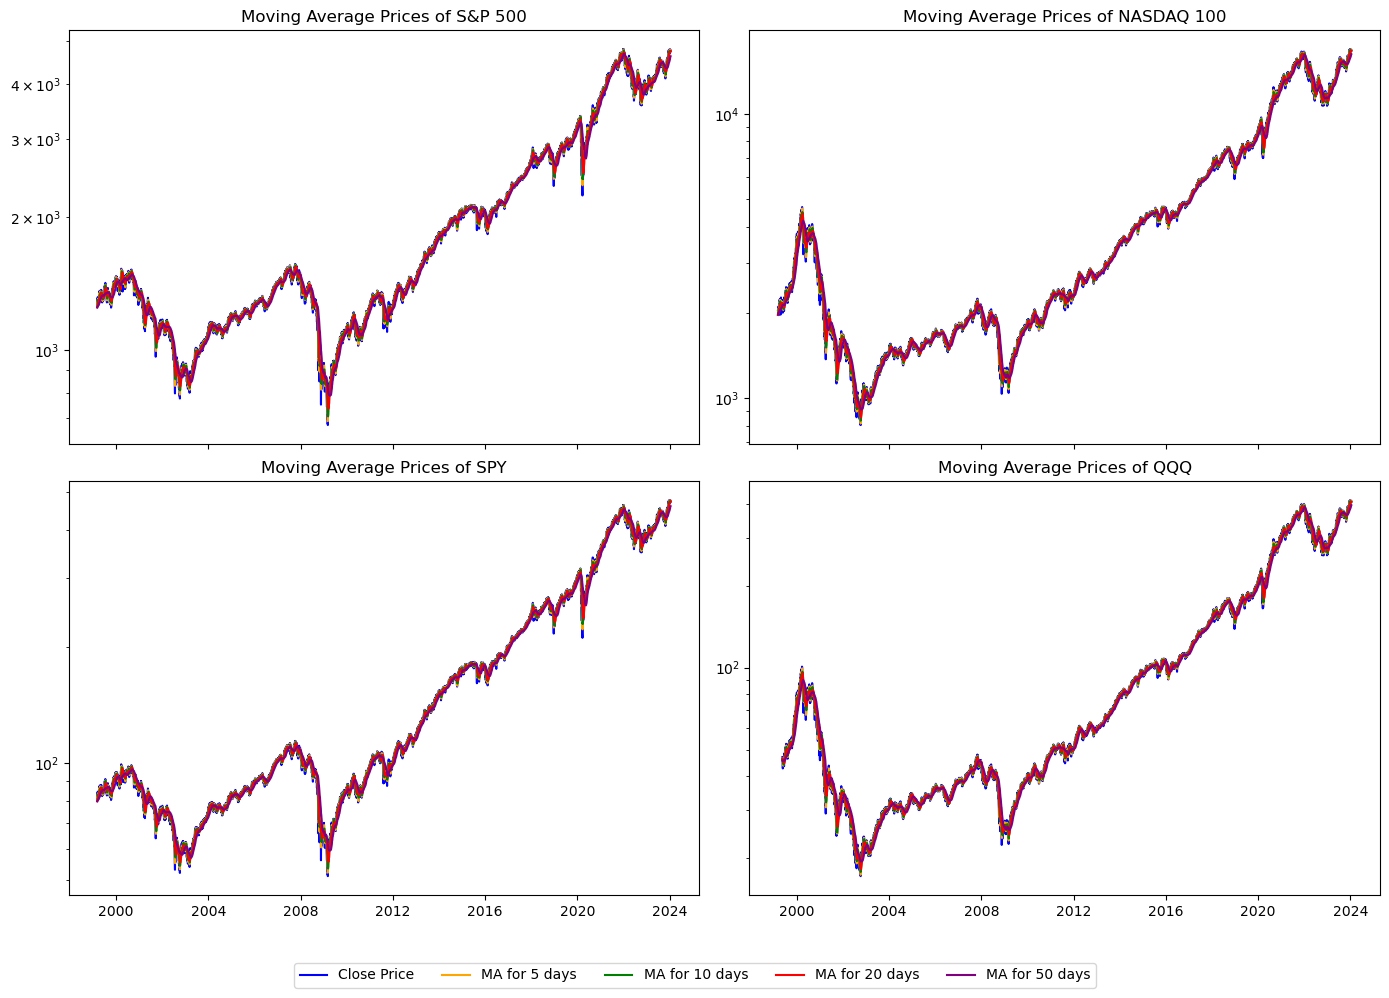

In [14]:
# compare moving average prices
# use log scale for better comparison

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, stock_index in zip(axes, label_list):
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    
    ax.plot(filtered_df.index, filtered_df['close'], label='Close Price', color='blue')
    ax.plot(filtered_df.index, filtered_df['avg_pri_5d'], label='MA for 5 days', color='orange')
    ax.plot(filtered_df.index, filtered_df['avg_pri_10d'], label='MA for 10 days', color='green')
    ax.plot(filtered_df.index, filtered_df['avg_pri_20d'], label='MA for 20 days', color='red')
    ax.plot(filtered_df.index, filtered_df['avg_pri_50d'], label='MA for 50 days', color='purple')

    ax.set_title(f"Moving Average Prices of {stock_index}")
    ax.set_yscale('log')  # Set y-axis to log scale

plt.tight_layout()
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.0))
fig.subplots_adjust(bottom=0.1)
plt.show()



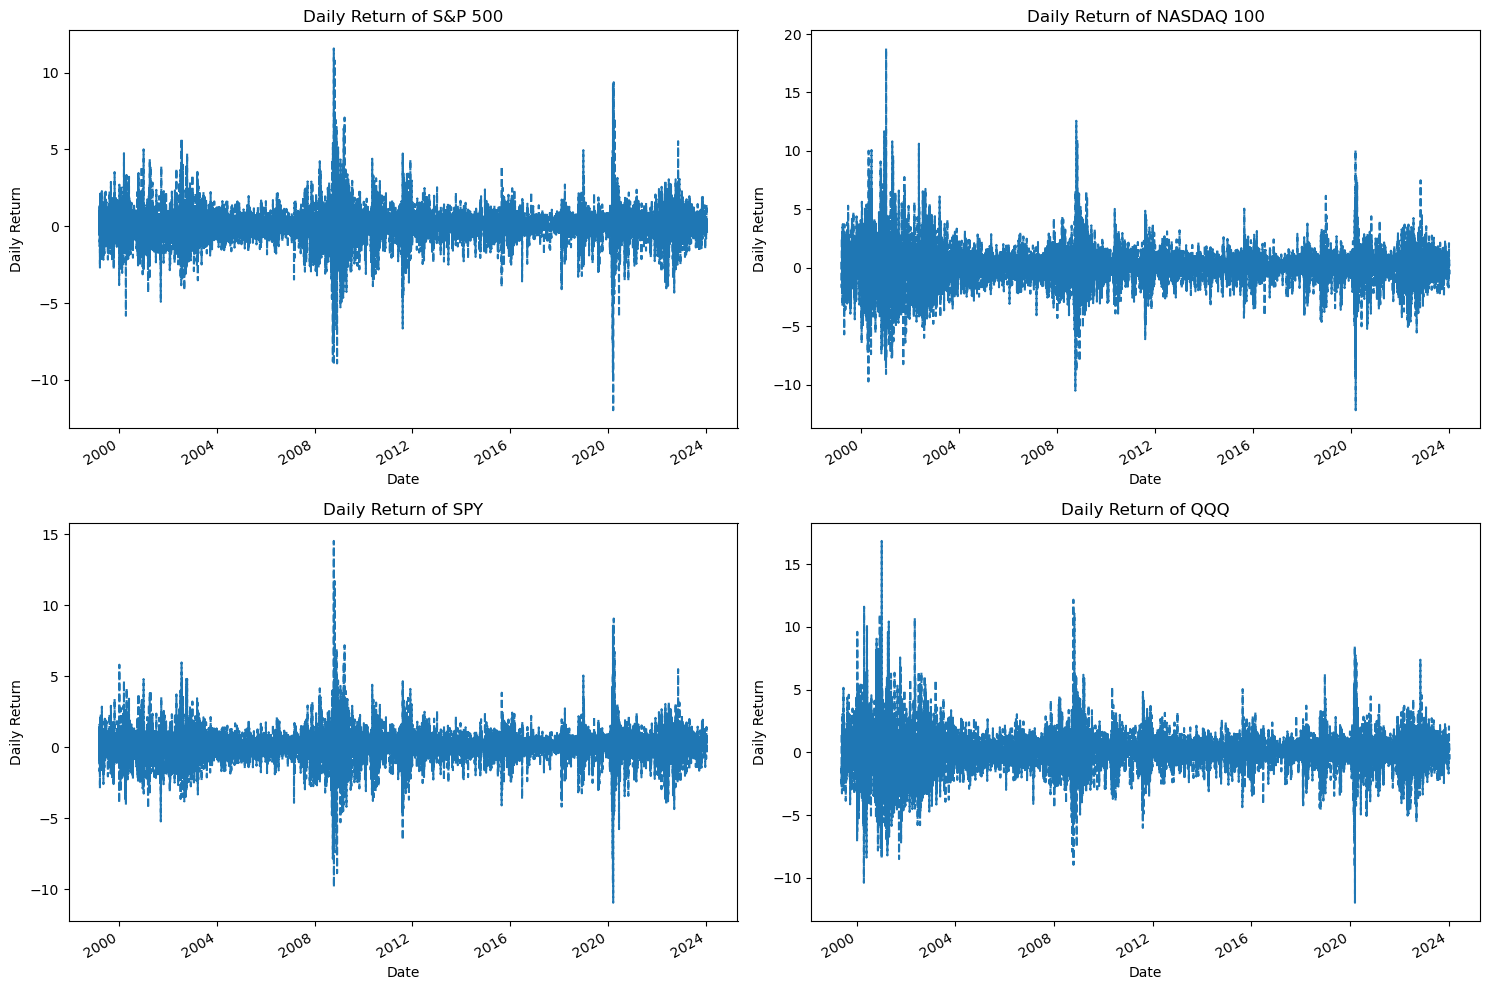

In [15]:
# compare daily returns
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['change_percent'].plot(linestyle='--')   
    plt.ylabel('Daily Return')
    plt.xlabel('Date')
    plt.title(f"Daily Return of {stock_index}")

plt.tight_layout()
plt.show()

For all indices, daily return witnesses severe fluctuations during global financial crisis and Covid-19 pandemic. Just like moving avergae prices, daily returns for Nasdaq 100 and QQQ perform similarly as QQQ passively follows Nasdaq 100.

We then look at the average daily return using a histogram, as we will use seaborn to create both a histogram and kde plot on the same figure.

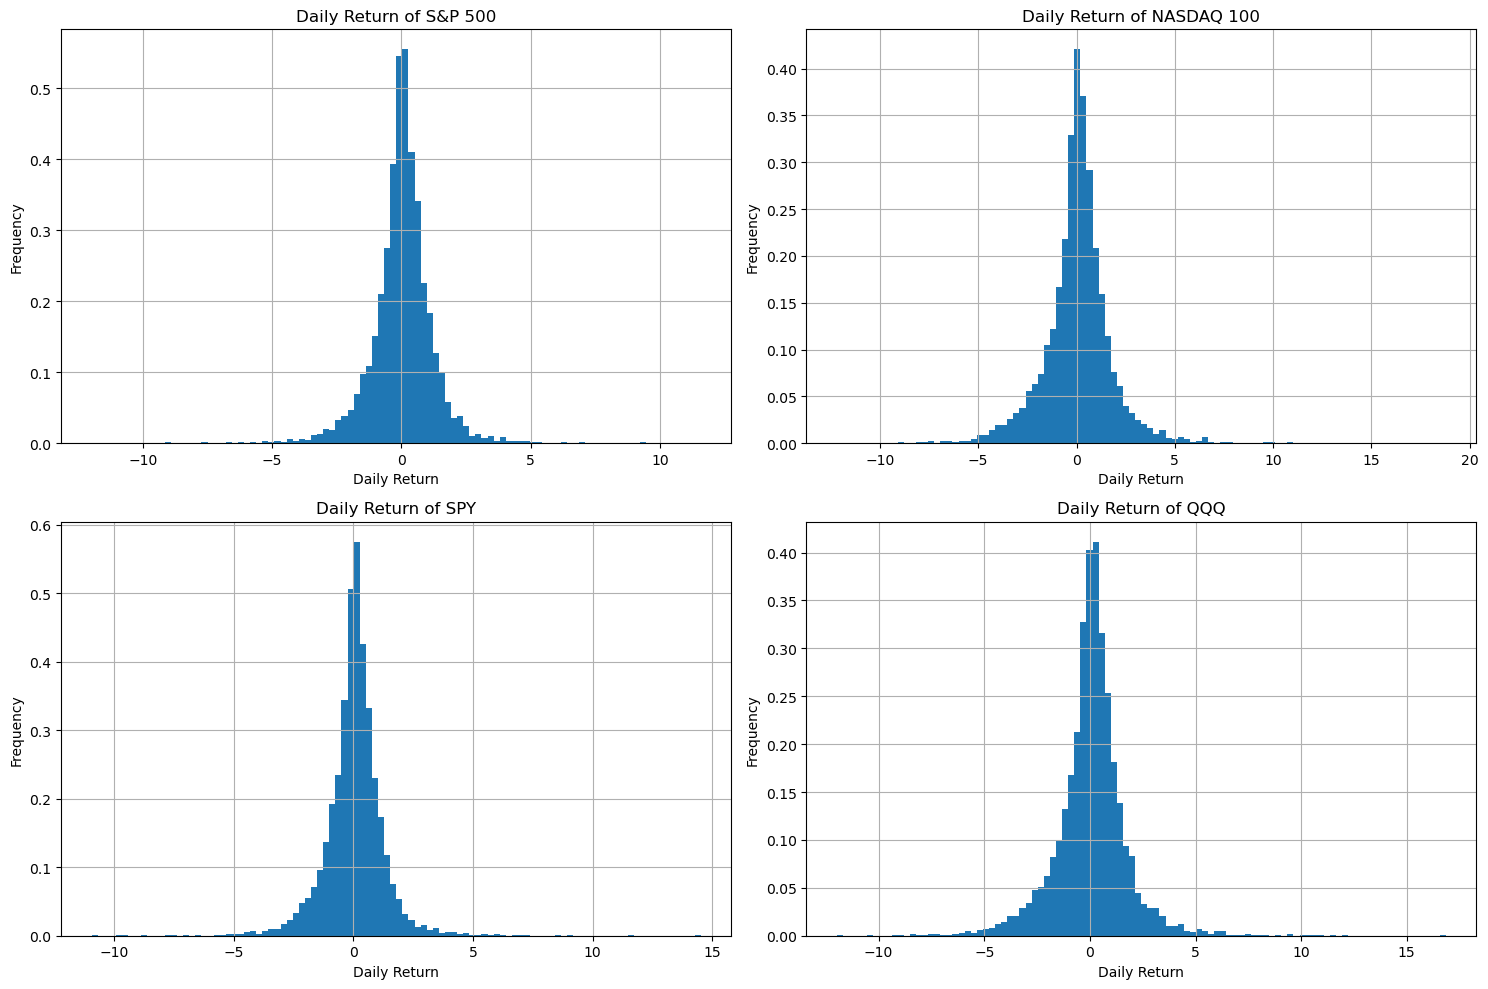

In [16]:
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['change_percent'].hist(bins=100, density=True)
    plt.ylabel('Frequency')
    plt.xlabel('Daily Return')
    plt.title(f"Daily Return of {stock_index}")

plt.tight_layout()
plt.show()

Finally, we visualise each index in more standardised candlestick chart to have a sense about the stock prices in 2023.

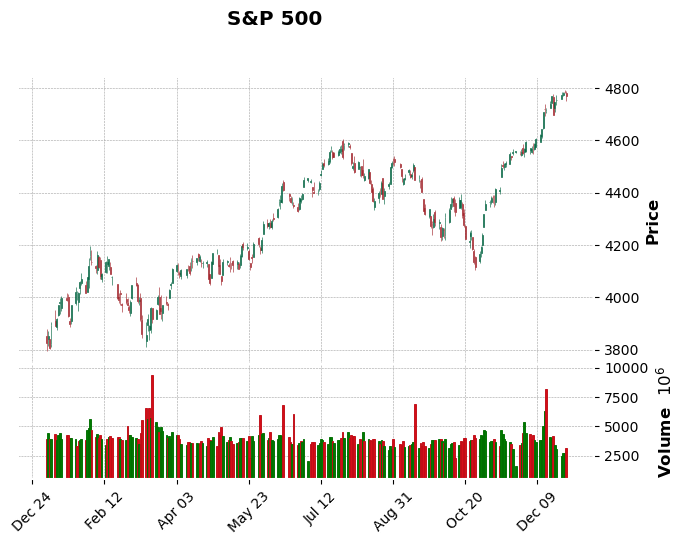

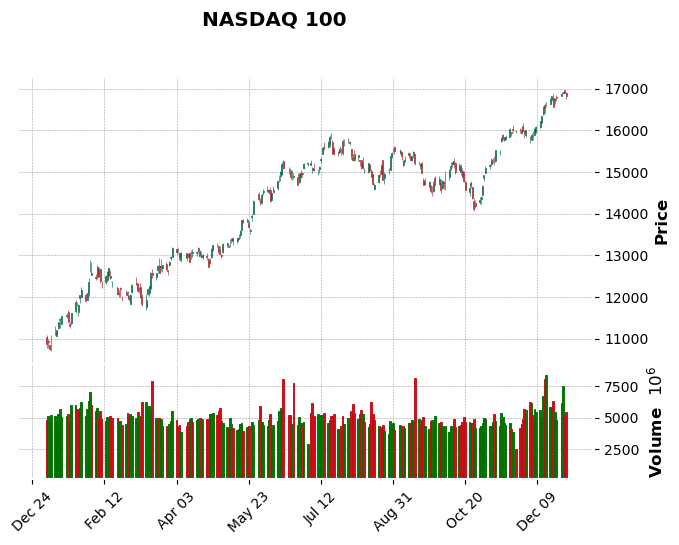

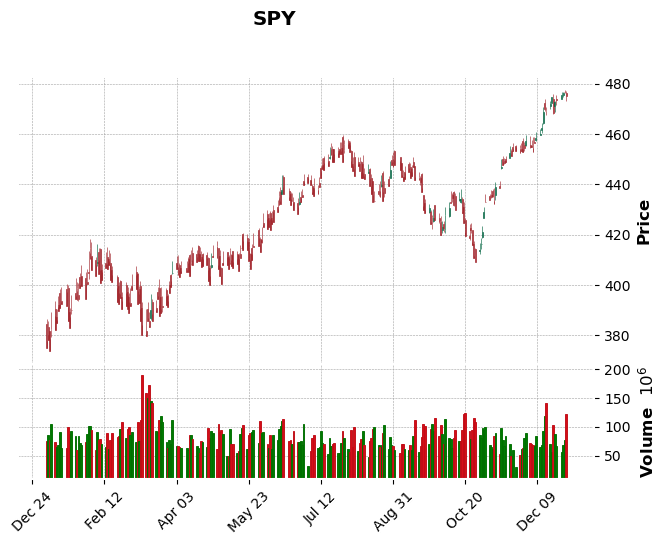

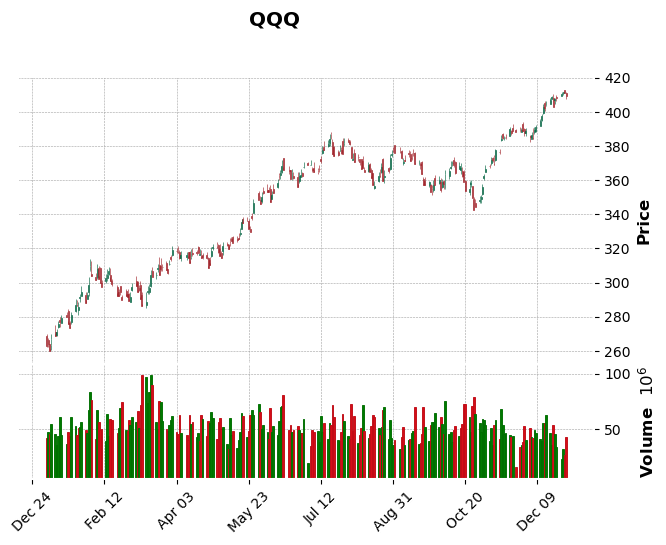

In [17]:
# plot candlestick chart for 2023
for i, stock_index in enumerate(label_list, 1):
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    # filter data for 2023
    df_2023 = filtered_df[filtered_df.index.year == 2023]
    # plot candlestick chart
    mpf.plot(df_2023, type='candle', volume=True, title=stock_index, style='charles', show_nontrading=True)


In [31]:
# Grab all the closing prices for the stock market index list into one DataFrame

closing_df = combined_df.pivot_table(index='date', columns='Stock Index', values='close')
closing_df.head()   

Stock Index,NASDAQ 100,QQQ,S&P 500,SPY
date,,,,
1999-03-10,2038.5100,NaN,1286.8400,82.5137
1999-03-11,2043.7600,NaN,1297.6801,83.4319
1999-03-12,2008.9600,NaN,1294.5900,82.6335
1999-03-15,2060.3401,NaN,1307.2600,83.8111
1999-03-16,2073.3101,NaN,1306.3800,83.4918


In [52]:
import warnings
warnings.filterwarnings('ignore')

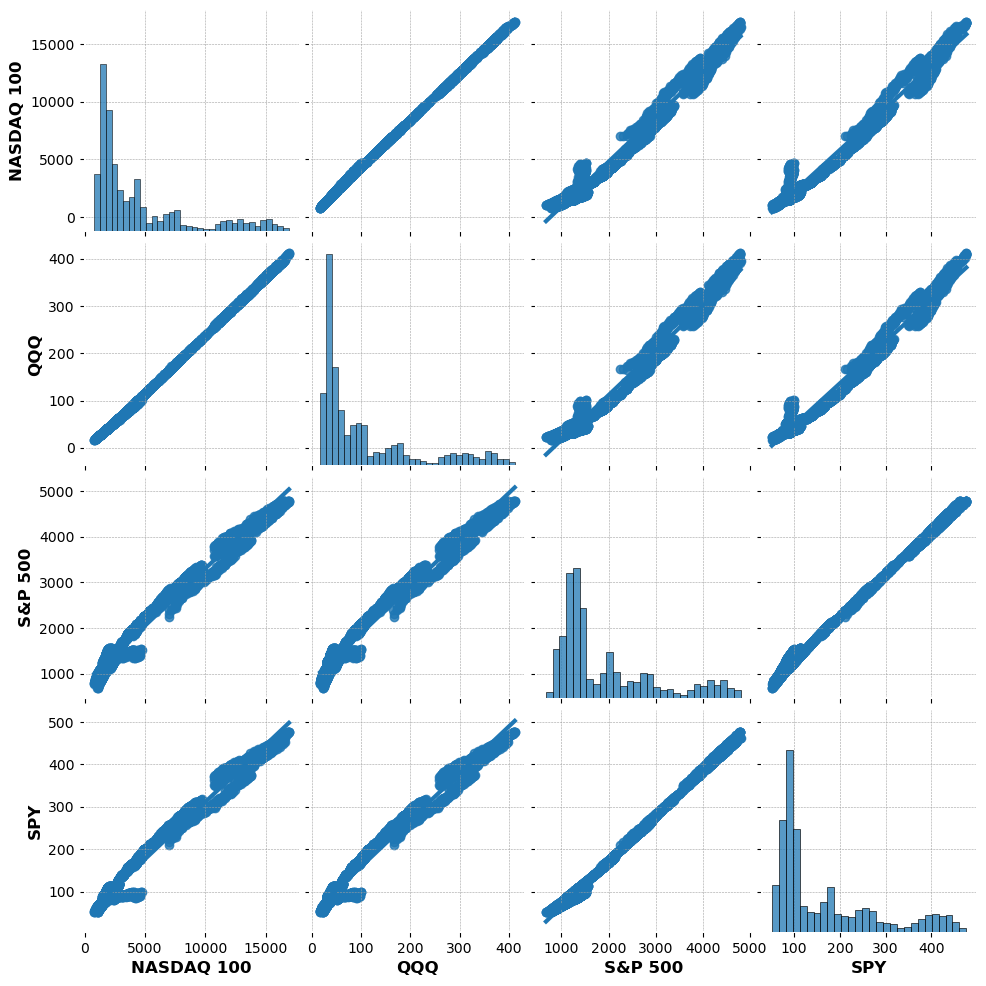

In [78]:
# Creating pairplot for an aoutomated visual analysis of closing prices of all the stock market indexes

sns.pairplot(closing_df, kind='reg')


The high positive correlations observed in both cases NASDAQ 100 vs. QQQ and SPY vs. S&P 500 are in line with the nature of stock markets. NASDAQ 100 and QQQ are linked due to the composition of the NASDAQ 100, while SPY mirrors the movements of the S&P 500. This alignment is consistent with the idea that certain ETFs or indices effectively represent the performance of the underlying market or sector. 

The correlation coefficient between NASDAQ100 and QQQ is quite high, indicating a strong positive correlation. This is expected since QQQ represents the performance of the NASDAQ100, and both tend to move in tandem. 

Similarly, as SPY is designed to track the performance of the S&P 500, the movements of these two are closely aligned. Investors often use SPY as a proxy for gaining exposure to the broader market represented by the S&P 500.

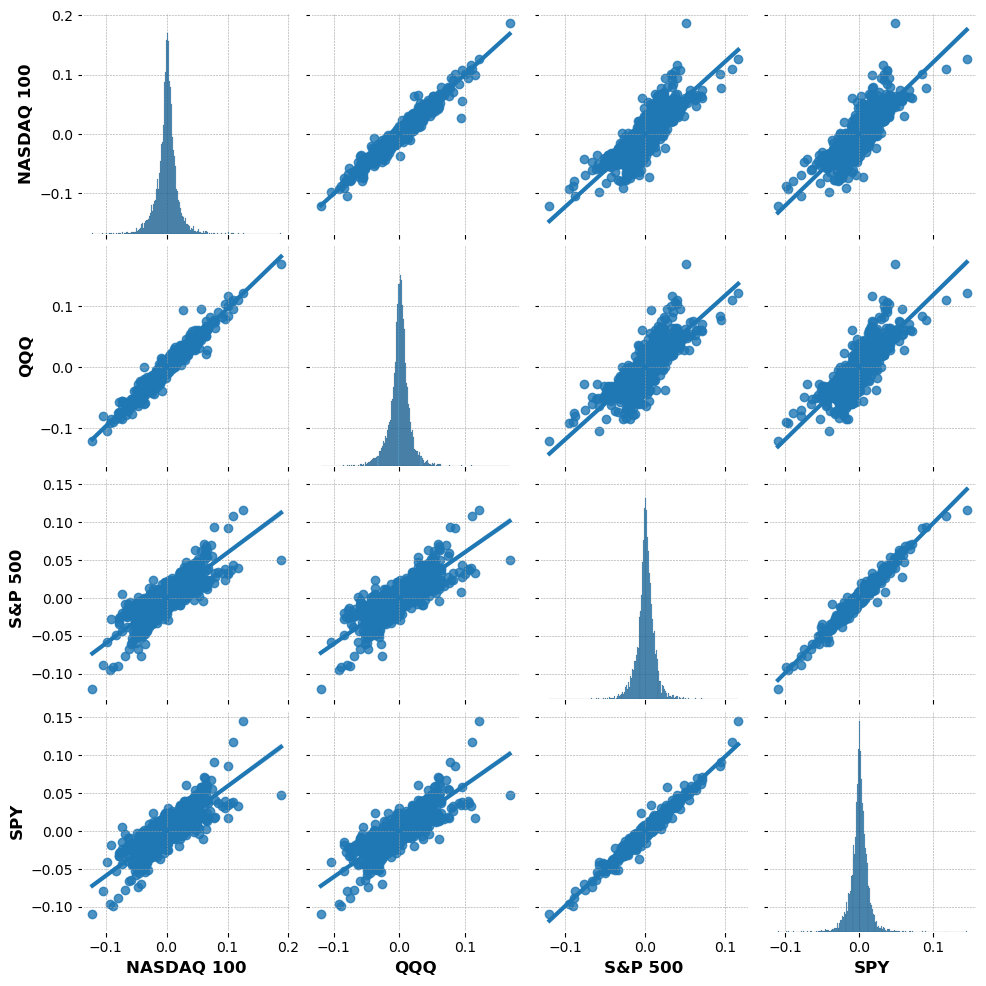

In [81]:
# Plotting a heatmap of the correlation between the closing prices of all the stock market indexes
sns.pairplot(daily_returns_df, kind='reg')

The persistence of positive correlations in both closing prices and daily returns underscores the stability of the relationships between NASDAQ 100 and QQQ, as well as SPY and the S&P 500. Whether analyzing closing prices or daily returns, investors and analysts can have confidence in the reliability of these instruments to capture the respective movements of their underlying benchmarks.

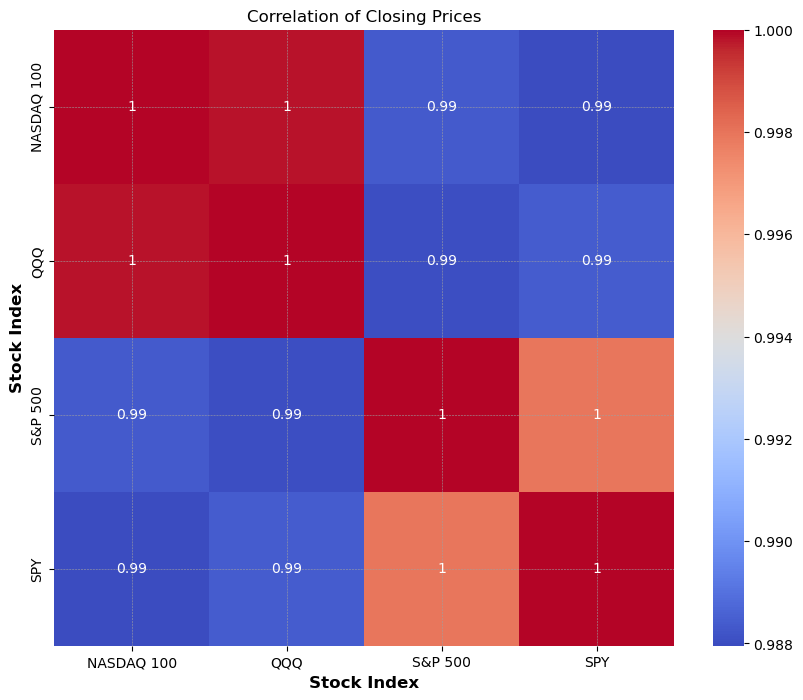

In [82]:
# Heatmap of the correlation between the closing prices of all the stock market indexes
plt.figure(figsize=(10, 8))
sns.heatmap(closing_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Closing Prices')
plt.show()


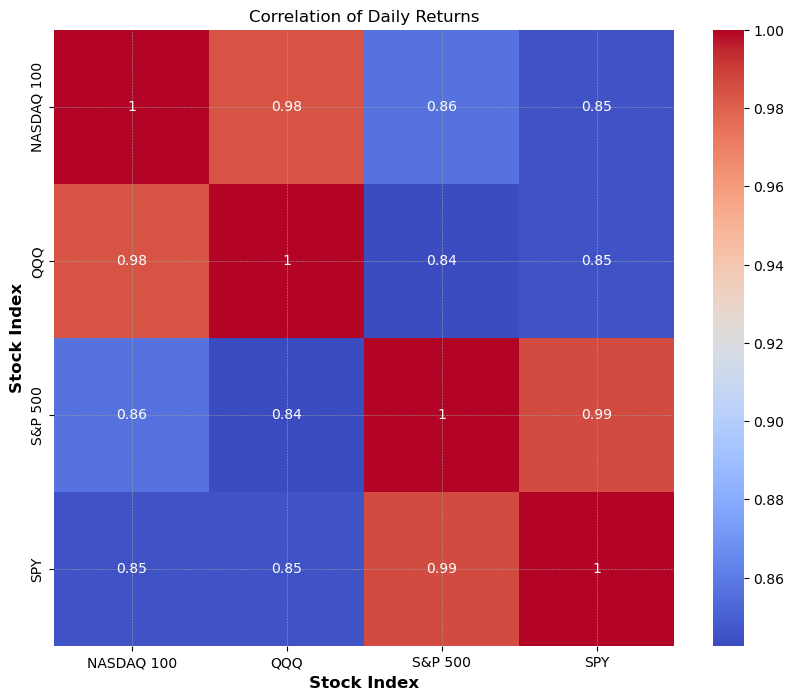

In [85]:
# Correlation plot for the daily returns of the stock market indexes
plt.figure(figsize=(10, 8))
returns_df = combined_df.pivot_table(index='date', columns='Stock Index', values='change_percent')
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Daily Returns')
plt.show()

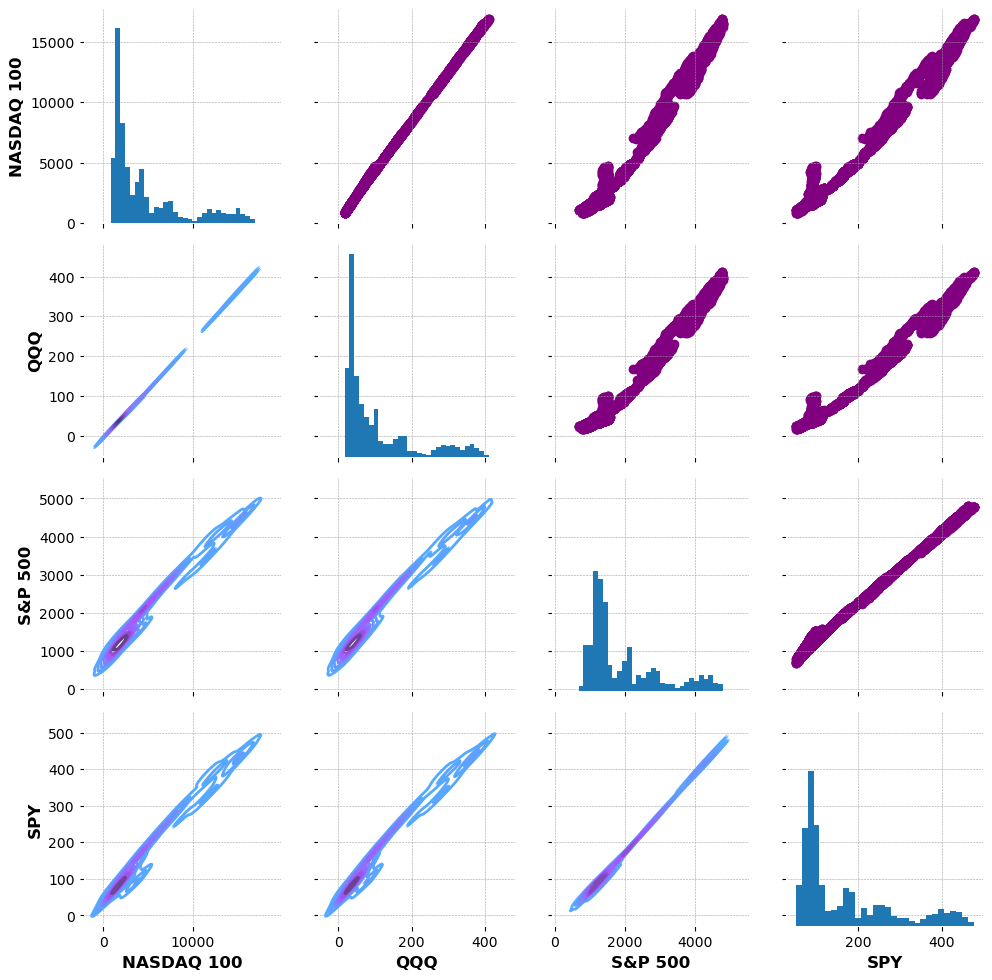

In [95]:
# Closing prices of the stock market indexes
closing_fig = sns.PairGrid(closing_df.dropna())
closing_fig.map_upper(plt.scatter, color='purple')
closing_fig.map_lower(sns.kdeplot, cmap='cool_d')
closing_fig.map_diag(plt.hist, bins=30)

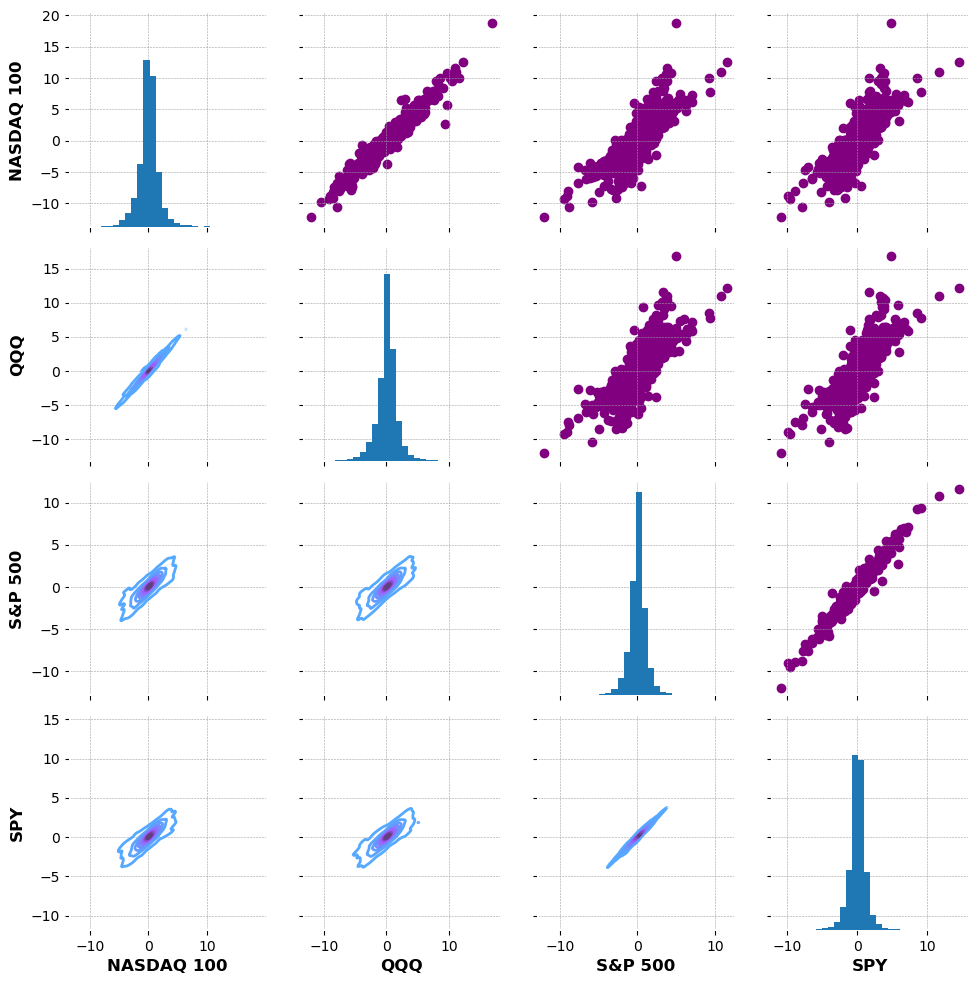

In [88]:
# Daily returns of the stock market indexes
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame 
returns_fig = sns.PairGrid(returns_df.dropna())

# Specifying upper triangle for the figure
returns_fig.map_upper(plt.scatter, color='purple')

# Defining the lower triangle in the figure
returns_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Defining the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist, bins=30)

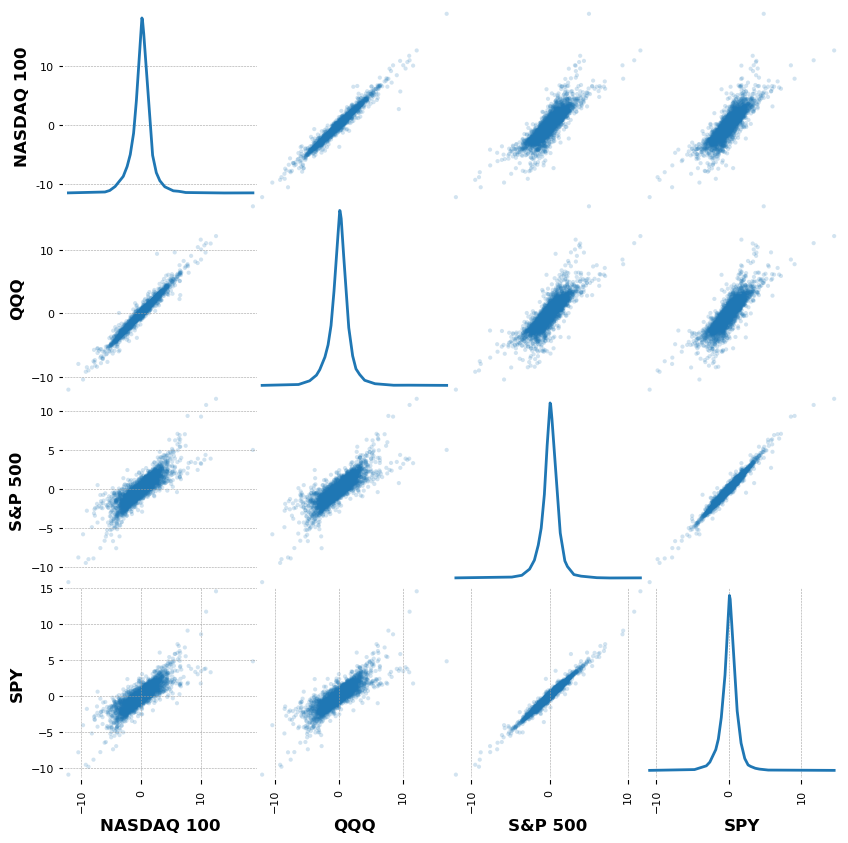

In [96]:
# Scatter matrix of the daily returns of the stock market indexes
from pandas.plotting import scatter_matrix
scatter_matrix(returns_df, alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.show()

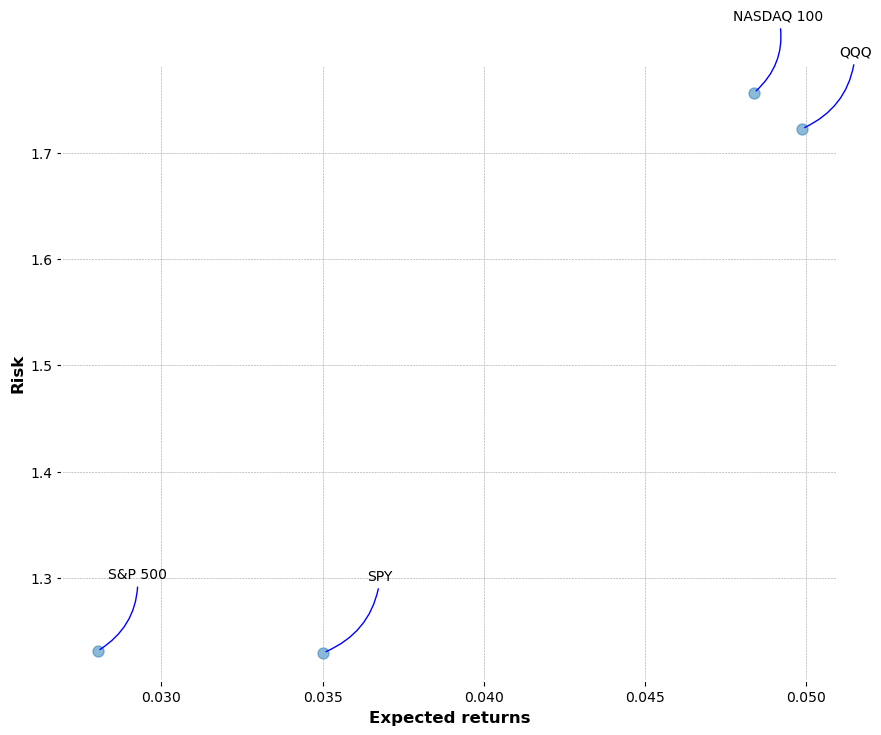

In [90]:
# Quantify the risk of an individual stock by comparing the expected return (which can be the mean of the daily returns) with the standard deviation of the daily returns

rets = returns_df.dropna()
area = np.pi*20
plt.figure(figsize=(10, 8))
plt.scatter(ret.mean(), ret.std(), alpha=0.5, s=area)
plt.xlabel('Expected returns')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

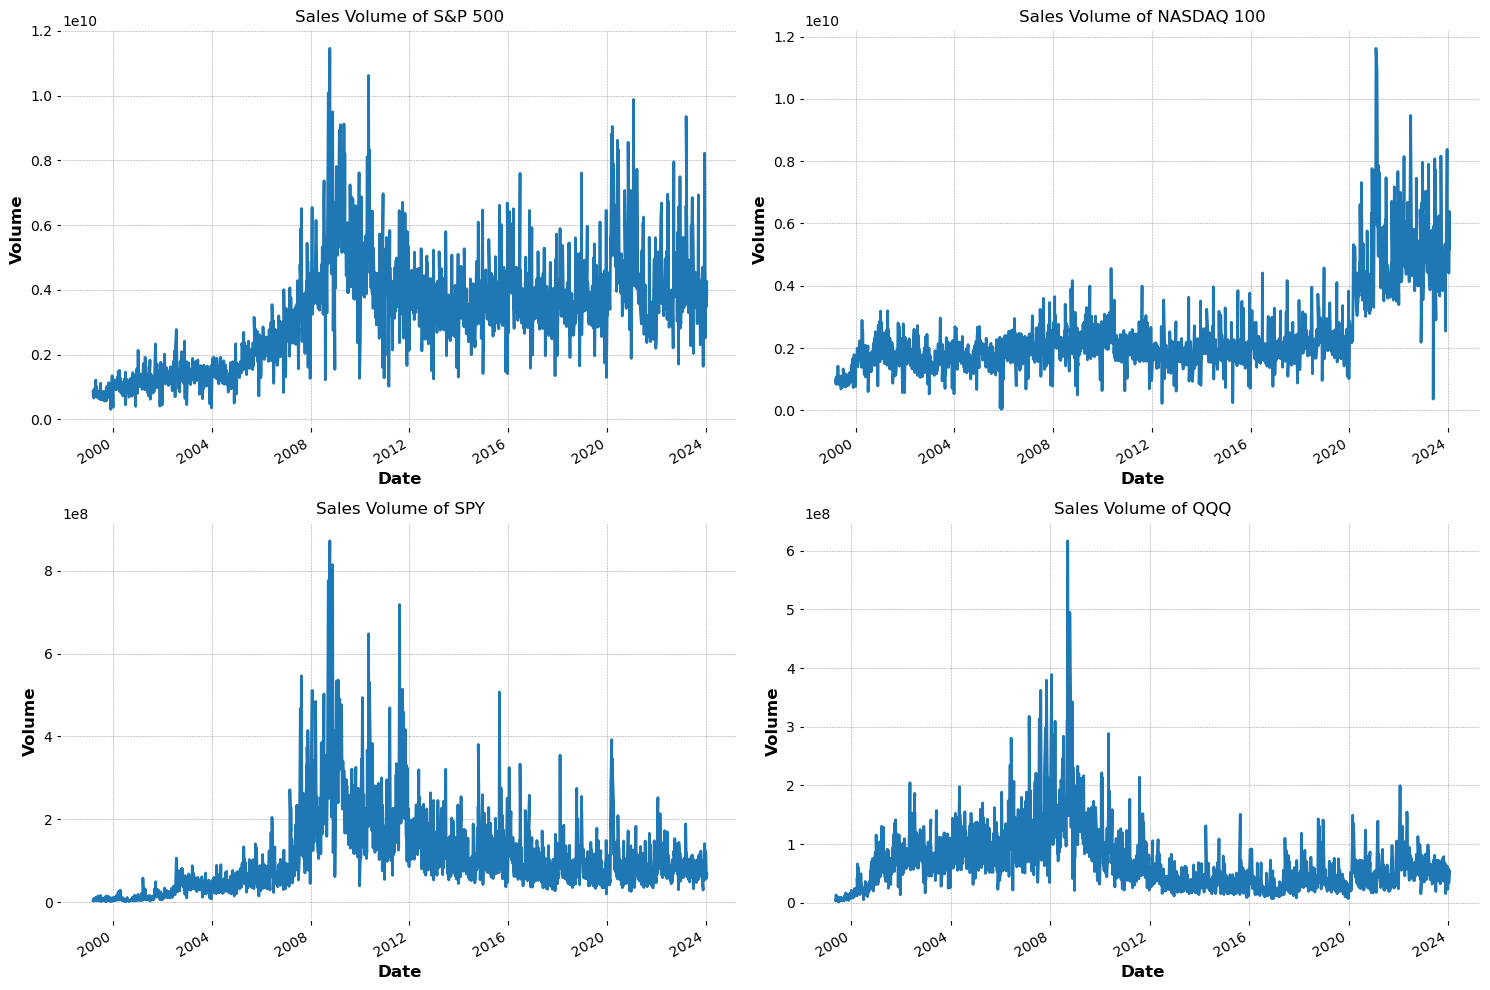

In [92]:
#COPY-PASTE from yijing's code, read below cell for explanation:)
# compare sales volume
plt.figure(figsize=(15, 10))

for i, stock_index in enumerate(label_list, 1):
    plt.subplot(2, 2, i)
    filtered_df = combined_df[combined_df['Stock Index'] == stock_index]
    filtered_df['volume'].plot()   
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"Sales Volume of {stock_index}")

plt.tight_layout()
plt.show()

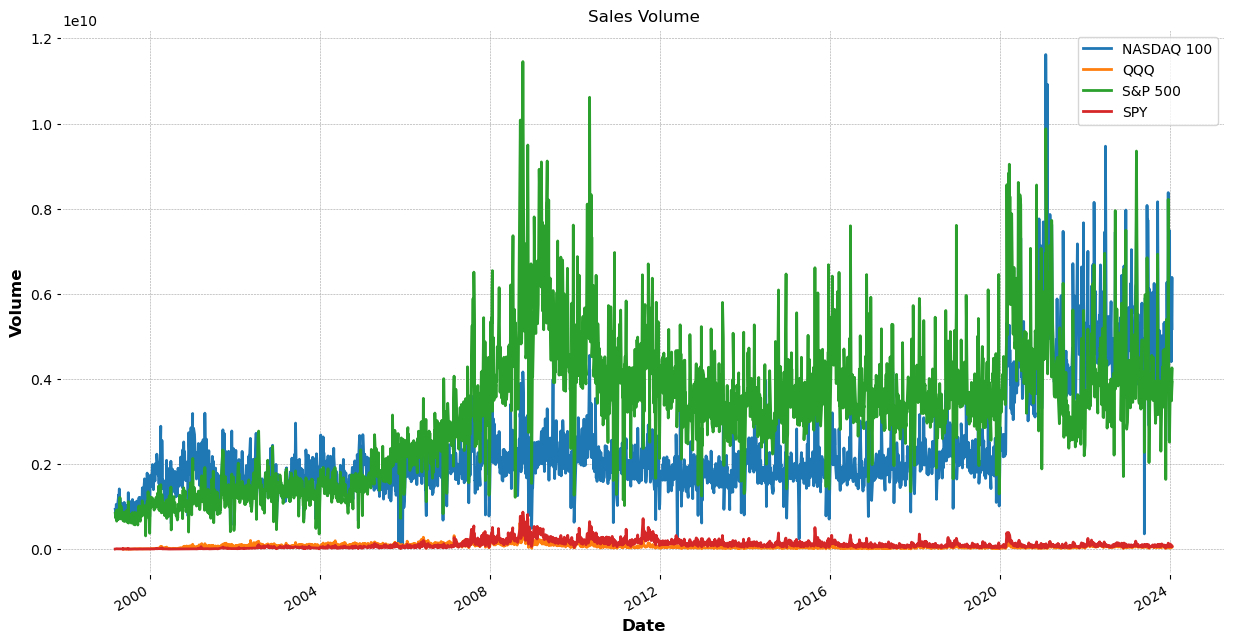

In [93]:
# SHALL WE ADD CODE  BELOW TO THE CODE BELOW TO SEE THE COMPARISON MORE CLEARLY?
# Comparing sales volume of the stock market indexes in one plot
plt.figure(figsize=(15, 8))
combined_df.groupby('Stock Index').volume.plot(legend=True)
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title('Sales Volume')
plt.show()
